In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats

In [2]:
import sep
import numpy as np

def extract_source(data, max_sources=50):
    # Calculate background statistics
    data = data.astype(np.float32)

    bkg = sep.Background(data)
    signal = data - bkg
    sources = sep.extract(signal, 1.5, err=bkg.globalrms, minarea=40)

    # Keep at most max_sources sources distributed evenly
    if len(sources) > max_sources:
        indices = np.linspace(0, len(sources)-1, max_sources, dtype=int)
        sources = sources[indices]

    return sources, signal


In [3]:
def plot_aperature(data, aperture):
    mask = aperture.to_mask(method='center')
    roi_data = mask.cutout(data)
    plt.imshow(roi_data, cmap='Greys', origin='lower')
    plt.colorbar(label='Intensity')
    plt.show()

In [4]:
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus
from photutils.centroids import centroid_quadratic
from photutils.profiles import RadialProfile

APERTURE_R = 10

def calc_hfd(signal, aperture):
    x = aperture.positions[0]
    y = aperture.positions[1]
    
    mask = aperture.to_mask(method='subpixel')
    roi_data = mask.cutout(signal)
    dist_weighted_flux = 0
    dist_pix_pairs = []
    for (y, x), pix in np.ndenumerate(roi_data):
        dx = x - aperture.r
        dy = y - aperture.r
        dist = np.sqrt(dy*dy+dx*dx)
        if dist < APERTURE_R:
            dist_weighted_flux += pix * dist
            dist_pix_pairs.append((dist, pix))  

    # total_flux = aperture_photometry(signal, aperture)['aperture_sum'][0]
    total_flux = np.sum(roi_data)
    my_hfd = dist_weighted_flux / total_flux * 2

    half_flux = total_flux / 2
    dist_pix_pairs.sort(key=lambda x: x[0])
    prev_dist, prev_pix = 0, 0
    dist, pix  = 0, 0 
    flux_acc = 0
    for dist, pix in dist_pix_pairs:
        flux_acc += pix
        if flux_acc > half_flux:
            break
        prev_dist = dist
        prev_pix = pix
    s = (dist - prev_dist) / (pix - prev_pix)

    phd_hfd = (prev_dist + (half_flux - prev_pix) * s) * 2

    return my_hfd, phd_hfd

def calc_fwhm(signal, aperture):
    xycen = aperture.positions
    edge_radii = np.arange(25)
    rp = RadialProfile(signal, xycen, edge_radii, mask=None)
    fwhm_value = rp.gaussian_fwhm
    # plot_aperature(signal, rp.apertures[-1])
    return fwhm_value

In [5]:
from glob import glob
images = glob('focus_test/manual/*.fits')
images.sort()
images

['focus_test/manual/2023-10-12_22-07-46_L_-15.00_2.00s_g60_0000.fits',
 'focus_test/manual/2023-10-12_22-07-56_L_-15.00_2.00s_g60_0000.fits',
 'focus_test/manual/2023-10-12_22-08-04_L_-14.90_2.00s_g60_0000.fits',
 'focus_test/manual/2023-10-12_22-08-13_L_-14.90_2.00s_g60_0000.fits',
 'focus_test/manual/2023-10-12_22-08-25_L_-15.00_2.00s_g60_0000.fits',
 'focus_test/manual/2023-10-12_22-08-41_L_-15.00_2.00s_g60_0000.fits',
 'focus_test/manual/2023-10-12_22-08-49_L_-14.90_2.00s_g60_0000.fits',
 'focus_test/manual/2023-10-12_22-08-57_L_-14.90_2.00s_g60_0000.fits',
 'focus_test/manual/2023-10-12_22-09-06_L_-14.90_2.00s_g60_0000.fits',
 'focus_test/manual/2023-10-12_22-09-14_L_-14.90_2.00s_g60_0000.fits',
 'focus_test/manual/2023-10-12_22-09-26_L_-15.00_2.00s_g60_0000.fits',
 'focus_test/manual/2023-10-12_22-09-33_L_-15.00_2.00s_g60_0000.fits',
 'focus_test/manual/2023-10-12_22-09-40_L_-14.90_2.00s_g60_0000.fits']

In [6]:
focuser_positions = []
sep_hfd_curve_dp = []

for img in images:
    hdul = fits.open(img)
    data = hdul[0].data
    current_focus = hdul[0].header['FOCUSPOS']
    sources, signal = extract_source(data)

    hfrs, flag = sep.flux_radius(signal, sources['x'], sources['y'], 
                              6.*sources['a'],
                              frac=0.5, 
                              subpix=5)
    median_sep_hfd = np.median(hfrs[flag==0]) * 2
    sep_hfd_curve_dp.append(median_sep_hfd)
    focuser_positions.append(current_focus)
    

In [7]:
fwhm_curve_dp = []
my_hfd_curve_dp = []
phd_hfd_curve_dp = []


for img in images:
    hdul = fits.open(img)
    data = hdul[0].data
    current_focus = hdul[0].header['FOCUSPOS']
    sources, signal = extract_source(data)
    x_coords = sources['x']
    y_coords = sources['y']
    x,y = list(zip(x_coords, y_coords))[0]

    # Calculate the FWHM for each detected star
    fwhm_values = []
    my_hfd_values = []
    phd_hfd_values = []
    for x, y in zip(x_coords, y_coords):
        aperture = CircularAperture((x, y), r=APERTURE_R)
        fwhm_value = calc_fwhm(signal, aperture)
        fwhm_values.append(fwhm_value)

        # HFD
        my_hfd, phd_hfd = calc_hfd(signal, aperture)
        my_hfd_values.append(my_hfd)
        phd_hfd_values.append(phd_hfd)

    
    fwhm_values = np.array(fwhm_values)

    median_fwhm = np.median(fwhm_values)
    fwhm_curve_dp.append(median_fwhm)

    median_my_hfd = np.median(my_hfd_values)
    my_hfd_curve_dp.append(median_my_hfd)
    median_phd_hfd = np.median(phd_hfd_values)
    phd_hfd_curve_dp.append(median_phd_hfd)


In [8]:
# fit the data with a quadratic
fwhm_fit = np.polyfit(focuser_positions, fwhm_curve_dp, 2)

# predict the minimum value
fwhm_min_value = -fwhm_fit[1] / (2 * fwhm_fit[0])

print(f"FWHM predicted focuser position is {fwhm_min_value:.2f}")

# fit the data with a quadratic
my_hfd_fit = np.polyfit(focuser_positions, my_hfd_curve_dp, 2)

# predict the minimum value
my_hfd_min_value = -my_hfd_fit[1] / (2 * my_hfd_fit[0])

print(f"my HFD predicted focuser position is {my_hfd_min_value:.2f}")

sep_hfd_fit = np.polyfit(focuser_positions, sep_hfd_curve_dp, 2)

# predict the minimum value
sep_hfd_min_value = -sep_hfd_fit[1] / (2 * sep_hfd_fit[0])

print(f"sep HFD predicted focuser position is {sep_hfd_min_value:.2f}")

phd_hfd_fit = np.polyfit(focuser_positions, phd_hfd_curve_dp, 2)

# predict the minimum value
phd_hfd_min_value = -phd_hfd_fit[1] / (2 * phd_hfd_fit[0])

print(f"phd HFD predicted focuser position is {phd_hfd_min_value:.2f}")


FWHM predicted focuser position is 13680.63
my HFD predicted focuser position is 13674.76
sep HFD predicted focuser position is 13677.17
phd HFD predicted focuser position is 13679.63


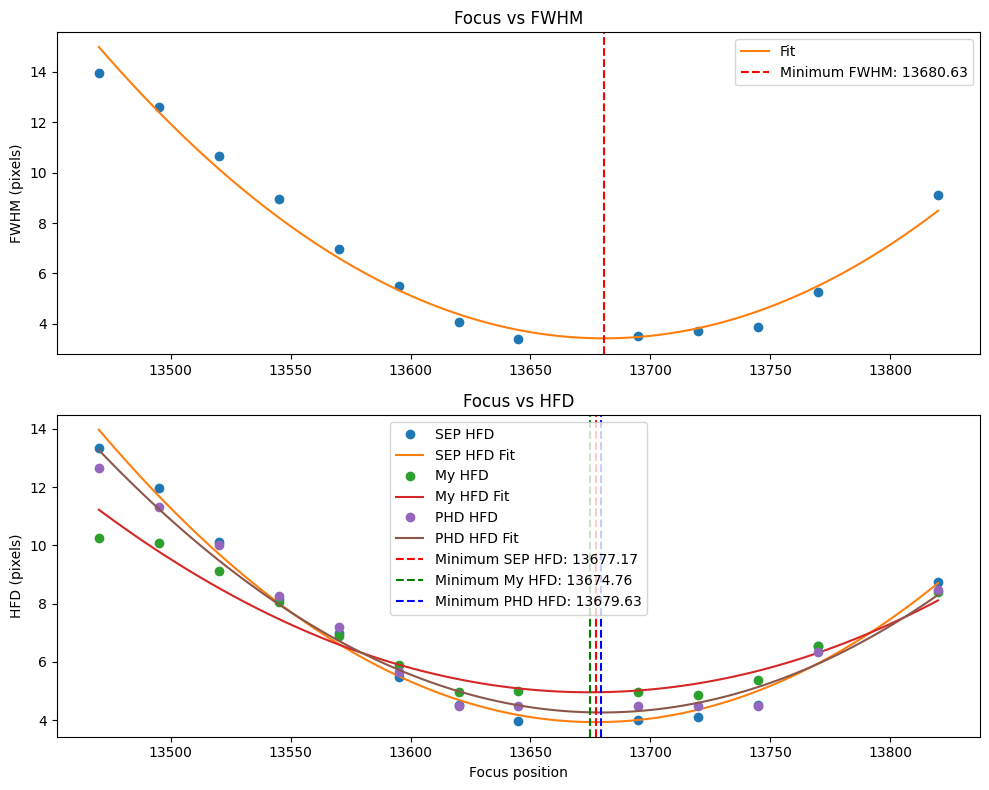

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

x_fit = np.linspace(min(focuser_positions), max(focuser_positions), 100)

# plot FWHM curve and fit
ax1.plot(focuser_positions, fwhm_curve_dp, 'o')
y_fit = np.polyval(fwhm_fit, x_fit)
ax1.plot(x_fit, y_fit, label='Fit')
ax1.set_ylabel('FWHM (pixels)')
ax1.set_title('Focus vs FWHM')

# plot HFD curves and fits
ax2.plot(focuser_positions, sep_hfd_curve_dp, 'o', label='SEP HFD')
y_fit = np.polyval(sep_hfd_fit, x_fit)
ax2.plot(x_fit, y_fit, label='SEP HFD Fit')

ax2.plot(focuser_positions, my_hfd_curve_dp, 'o', label='My HFD')
y_fit = np.polyval(my_hfd_fit, x_fit)
ax2.plot(x_fit, y_fit, label='My HFD Fit')

ax2.plot(focuser_positions, phd_hfd_curve_dp, 'o', label='PHD HFD')
y_fit = np.polyval(phd_hfd_fit, x_fit)
ax2.plot(x_fit, y_fit, label='PHD HFD Fit')

ax2.set_xlabel('Focus position')
ax2.set_ylabel('HFD (pixels)')
ax2.set_title('Focus vs HFD')

# mark the minimum value of the fits
fwhm_min_value = -fwhm_fit[1] / (2 * fwhm_fit[0])
ax1.axvline(fwhm_min_value, color='r', linestyle='--', label=f'Minimum FWHM: {fwhm_min_value:.2f}')

sep_hfd_min_value = -sep_hfd_fit[1] / (2 * sep_hfd_fit[0])
ax2.axvline(sep_hfd_min_value, color='r', linestyle='--', label=f'Minimum SEP HFD: {sep_hfd_min_value:.2f}')

my_hfd_min_value = -my_hfd_fit[1] / (2 * my_hfd_fit[0])
ax2.axvline(my_hfd_min_value, color='g', linestyle='--', label=f'Minimum My HFD: {my_hfd_min_value:.2f}')

phd_hfd_min_value = -phd_hfd_fit[1] / (2 * phd_hfd_fit[0])
ax2.axvline(phd_hfd_min_value, color='b', linestyle='--', label=f'Minimum PHD HFD: {phd_hfd_min_value:.2f}')

ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()
